In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Случайный лес

In [2]:
class RandomForestMSE:
    
    def __init__(
        self, n_estimators, max_depth=None, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        if feature_subsample_size is None:
            feature_subsample_size = 1/3
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        
        # trees_parameters
        self.random_state = 42
        self.eps_val = None
        self.continuity = False
        
        for param_name, value in trees_parameters.items():
            if param_name == "random_state":
                self.random_state = value
            if param_name == "eps_val":
                self.eps_val = value
            if param_name == "continuity":
                self.continuity = value
                
        self.b_list = None
        self.continuity_list = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features

        y_val : numpy ndarray
            Array of size n_val_objects
        """
        b_list = []
        np.random.seed(self.random_state)
        for t in range(self.n_estimators):
            # с возвращением
            u_mask = np.random.randint(X.shape[0], size=X.shape[0])
            U = X[u_mask]
            y_u = y[u_mask]
            
            b = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.feature_subsample_size, 
                                      random_state=self.random_state)
            b.fit(U, y_u)
            b_list.append(b)
            
            if (X_val != None) and (y_val != None) and (eps_val != None):
                pred_val = b.predict(X_val)
                if mean_squared_error(y_val, pred_val) > self.eps_val:
                    b_list.pop()
            
                
        self.b_list = b_list

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        T_continuity = 0
        T = len(self.b_list)
        if T == 0:
            raise TypeError("RandomForestMSE predict: T == 0")
        
        predict = np.zeros(X.shape[0])
        for b in self.b_list:
            predict += b.predict(X)
            if self.continuity:
                T_continuity += 1
                self.continuity_list.append(predict / T_continuity)
        predict = predict / T
        
        return predict
    
    def predict_y(self, X, y):
        rmse_list = []
        T_continuity = 0
        predict = np.zeros(X.shape[0])
        for b in self.b_list:
            predict += b.predict(X)
            T_continuity += 1
            rmse_list.append(mean_squared_error(y, predict / T_continuity, squared=False))
        return rmse_list

## Градиентный бустинг

In [3]:
class GradientBoostingMSE:
    
    def __init__(
        self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
        **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.

        learning_rate : float
            Use alpha * learning_rate instead of alpha

        max_depth : int
            The maximum depth of the tree. If None then there is no limits.

        feature_subsample_size : float
            The size of feature set for each tree. If None then use one-third of all features.
        """
        if feature_subsample_size is None:
            feature_subsample_size = 1/3
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.feature_subsample_size = feature_subsample_size
        
        # trees_parameters
        self.random_state = 42
        self.continuity = False
        
        for param_name, value in trees_parameters.items():
            if param_name == "random_state":
                self.random_state = value
            if param_name == "continuity":
                self.continuity = value
        
        self.b_list = None
        self.alpha_list = None

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        y : numpy ndarray
            Array of size n_objects
        """
        self.b_list = []
        self.alpha_list = []
        f = np.zeros_like(y)
        np.random.seed(self.random_state)
        
        for t in range(self.n_estimators):
            y_grad = 2 * (f - y)
            
            b = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.feature_subsample_size,
                                      random_state=self.random_state)
            b.fit(X, -y_grad)
            y_pred = b.predict(X)
            
            def fun(x):
                return mean_squared_error(f + x * y_pred, y)
            alpha = minimize_scalar(fun).x
            
            if alpha >= 0:
                self.b_list.append(b)
                self.alpha_list.append(alpha)
            
            f += alpha * self.learning_rate * y_pred

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features

        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        predict = np.zeros(X.shape[0])
        for b, alpha in zip(self.b_list, self.alpha_list):
            predict += self.learning_rate * alpha * b.predict(X)
        
        return predict
    
    def predict_y(self, X, y):
        rmse_list = []
        predict = np.zeros(X.shape[0])
        for b, alpha in zip(self.b_list, self.alpha_list):
            predict += self.learning_rate * alpha * b.predict(X)
            rmse_list.append(mean_squared_error(y, predict, squared=False))
        
        return rmse_list

## Эксперименты

### №1

Проведите предобработку имеющихся данных. Разделите данные на обучение и контроль, переведите данные в numpy.ndarray. Опишите выполненную предобработку данных в отчёте.

In [4]:
data = pd.read_csv('kc_house_data.csv')

In [5]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [6]:
X = data.drop(columns=['price', 'id', 'date']).values
y = data.price.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### №2

Исследуйте поведение алгоритма случайный лес. Изучите зависимость RMSE на отложенной выборке
и время работы алгоритма в зависимости от следующих факторов:

• количество деревьев в ансамбле

• размерность подвыборки признаков для одного дерева

• максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)

In [8]:
n_estimators_list_rf = [1, 5, 10, 20, 50, 100, 200, 300, 500] #9
feature_subsample_size_list_rf = [0.1, 0.3, 0.5, 0.8, 1.0] #5
max_depth_list_rf = [1, 3, 5, 7, 10, 15, None] #7
# 315

In [52]:
rmse_dict_rf = {}
time_dict_rf = {}
best_rmse_rf = 10**6
best_param_rf = (0, 0, 0)
global_start_time = time.time()


for n_estimators in n_estimators_list_rf:
    rmse_dict_rf[n_estimators] = {}
    time_dict_rf[n_estimators] = {}
    for feature_subsample_size in feature_subsample_size_list_rf:
        rmse_dict_rf[n_estimators][feature_subsample_size] = {}
        time_dict_rf[n_estimators][feature_subsample_size] = {}
        for max_depth in max_depth_list_rf:
            regressor = RandomForestMSE(n_estimators, max_depth=max_depth,
                                        feature_subsample_size=feature_subsample_size, random_state=42)
            start_time = time.time()
            regressor.fit(X_train, y_train)
            fit_time = time.time() - start_time
            
            y_pred = regressor.predict(X_test)
            
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            if rmse < best_rmse_rf:
                best_rmse_rf = rmse
                best_param_rf = (n_estimators, feature_subsample_size, max_depth)
            
            rmse_dict_rf[n_estimators][feature_subsample_size][max_depth] = rmse
            time_dict_rf[n_estimators][feature_subsample_size][max_depth] = fit_time  

global_time_rf = time.time() - global_start_time

In [53]:
print("Общее время обучения для RandomForestMSE %5.2f секунд" % (global_time_rf))
print(f"Лучший RMSE для RandomForestMSE: {best_rmse_rf:.3f}")
print("Лучшие параметры для RandomForestMSE:", best_param_rf)

Общее время обучения для RandomForestMSE 1346.93 секунд
Лучший RMSE для RandomForestMSE: 134915.060
Лучшие параметры для RandomForestMSE: (100, 0.3, None)


Общее время обучения для RandomForestMSE: 22 минуты

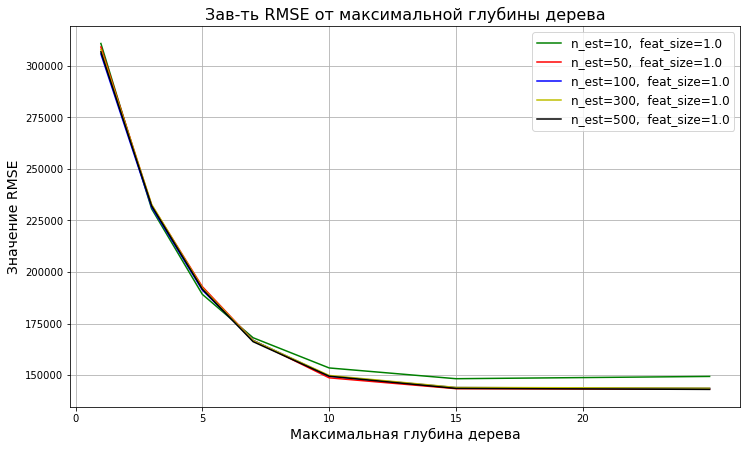

In [32]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть RMSE от максимальной глубины дерева", fontsize=16)
plt.xlabel("Максимальная глубина дерева", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)
            
size = 1.0
colors = ['g', 'r', 'b', 'y', 'k']
max_depth_list_rf_none = [1, 3, 5, 7, 10, 15, 25]
n_est = [10, 50, 100, 300, 500]
for i, n_estimators in enumerate(n_est):
    label = 'n_est=' + str(n_estimators) + ',  feat_size=' + str(size)
    plt.plot(max_depth_list_rf_none, rmse_dict_rf[n_estimators][size].values(), color=colors[i], label=label)

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0, 24, 5))
plt.grid()
plt.show()
# fig.savefig("depth_1.pdf", bbox_inches = 'tight')

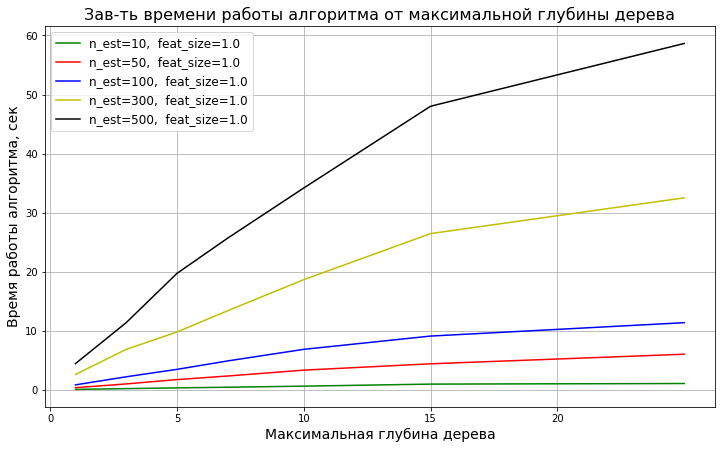

In [37]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть времени работы алгоритма от максимальной глубины дерева", fontsize=16)
plt.xlabel("Максимальная глубина дерева", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)
            
size = 1.0
colors = ['g', 'r', 'b', 'y', 'k']
max_depth_list_rf_none = [1, 3, 5, 7, 10, 15, 25]
n_est = [10, 50, 100, 300, 500]
for i, n_estimators in enumerate(n_est):
    label = 'n_est=' + str(n_estimators) + ',  feat_size=' + str(size)
    plt.plot(max_depth_list_rf_none, time_dict_rf[n_estimators][size].values(), color=colors[i], label=label)

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0, 24, 5))
plt.grid()
plt.show()
# fig.savefig("time_depth_1.pdf", bbox_inches = 'tight')

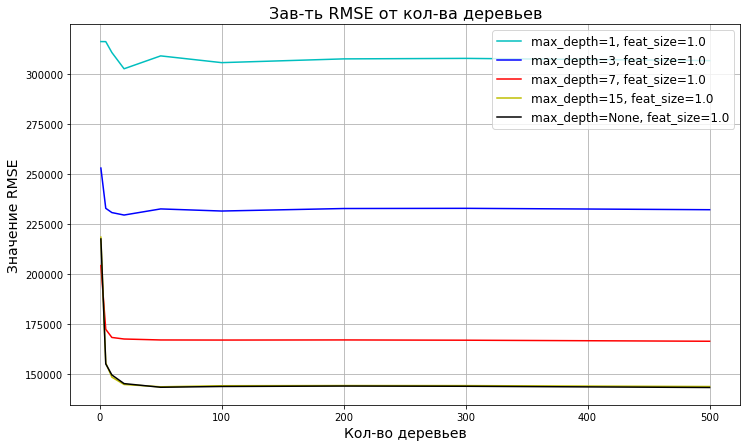

In [45]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)

size = 1.0
value_dict = {}
for max_depth in max_depth_list_rf:
    value_dict[max_depth] = []
    for n_estimators in n_estimators_list_rf:
            value_dict[max_depth].append(rmse_dict_rf[n_estimators][size][max_depth])
    
plt.plot(n_estimators_list_rf, value_dict[1], color="c", label="max_depth=1, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[3], color="b", label="max_depth=3, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[7], color="r", label="max_depth=7, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[15], color="y", label="max_depth=15, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[None], color="k", label="max_depth=None, feat_size=" + str(size))

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("n_1.pdf", bbox_inches = 'tight')

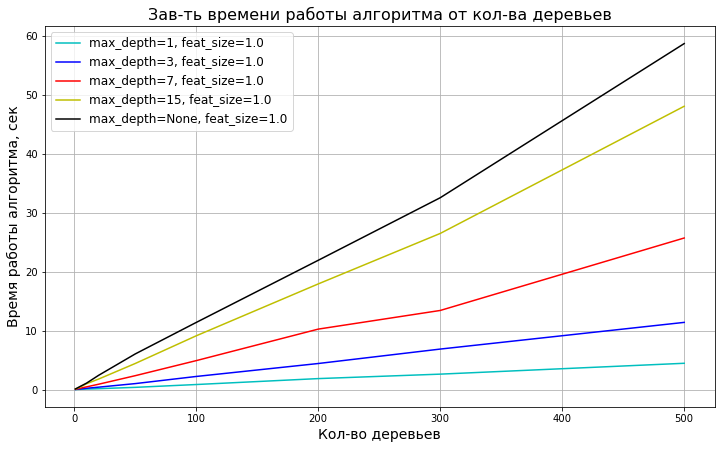

In [51]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть времени работы алгоритма от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)

size = 1.0
value_dict = {}
for max_depth in max_depth_list_rf:
    value_dict[max_depth] = []
    for n_estimators in n_estimators_list_rf:
            value_dict[max_depth].append(time_dict_rf[n_estimators][size][max_depth])
    
plt.plot(n_estimators_list_rf, value_dict[1], color="c", label="max_depth=1, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[3], color="b", label="max_depth=3, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[7], color="r", label="max_depth=7, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[15], color="y", label="max_depth=15, feat_size=" + str(size))
plt.plot(n_estimators_list_rf, value_dict[None], color="k", label="max_depth=None, feat_size=" + str(size))

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("time_n_1.pdf", bbox_inches = 'tight')

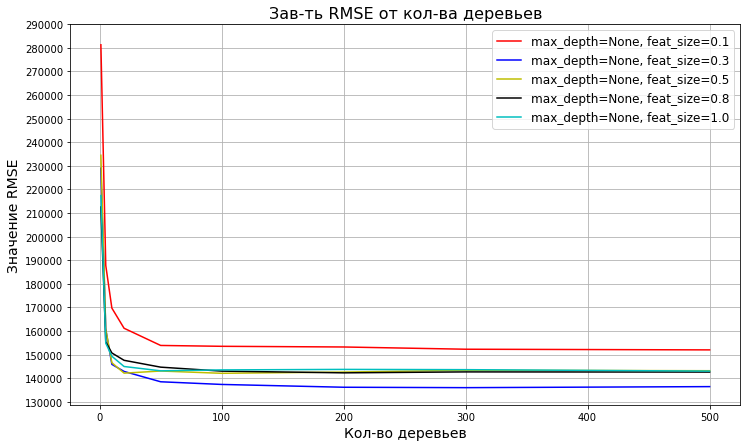

In [52]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть RMSE от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)

value_dict = {}
for feature_subsample_size in feature_subsample_size_list_rf:
    value_dict[feature_subsample_size] = []
    for n_estimators in n_estimators_list_rf:
            value_dict[feature_subsample_size].append(rmse_dict_rf[n_estimators][feature_subsample_size][None])
    
plt.plot(n_estimators_list_rf, value_dict[0.1], color="r", label="max_depth=None, feat_size=0.1")
plt.plot(n_estimators_list_rf, value_dict[0.3], color="b", label="max_depth=None, feat_size=0.3")
plt.plot(n_estimators_list_rf, value_dict[0.5], color="y", label="max_depth=None, feat_size=0.5")
plt.plot(n_estimators_list_rf, value_dict[0.8], color="k", label="max_depth=None, feat_size=0.8")
plt.plot(n_estimators_list_rf, value_dict[1.0], color="c", label="max_depth=None, feat_size=1.0")

ax.legend(loc=0, fontsize=12)
plt.yticks(np.arange(130000, 300000, 10000))
plt.grid()
plt.show()
# fig.savefig("n_None.pdf", bbox_inches = 'tight')

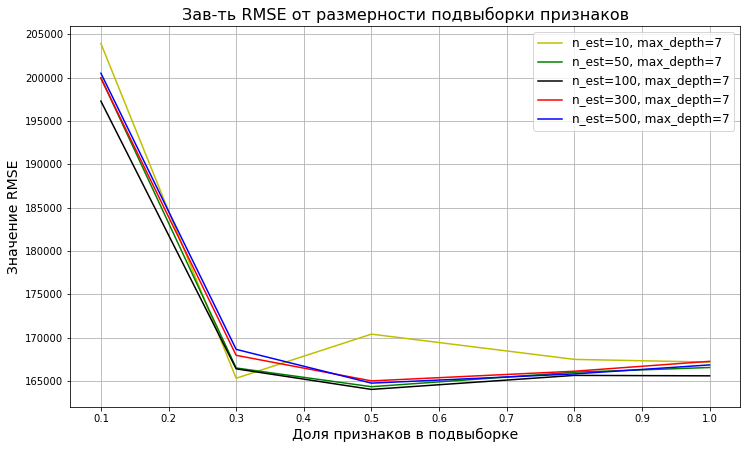

In [58]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от размерности подвыборки признаков", fontsize=16)
plt.xlabel("Доля признаков в подвыборке", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)


depth = 7
value_dict = {}
for n_estimators in n_estimators_list_rf:
    value_dict[n_estimators] = []
    for feature_subsample_size in feature_subsample_size_list_rf:
            value_dict[n_estimators].append(rmse_dict_rf[n_estimators][feature_subsample_size][depth])

plt.plot(feature_subsample_size_list_rf, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[300], color="r", label="n_est=300, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[500], color="b", label="n_est=500, max_depth=" + str(depth))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.grid()
plt.show()
# fig.savefig("size_7.pdf", bbox_inches = 'tight')

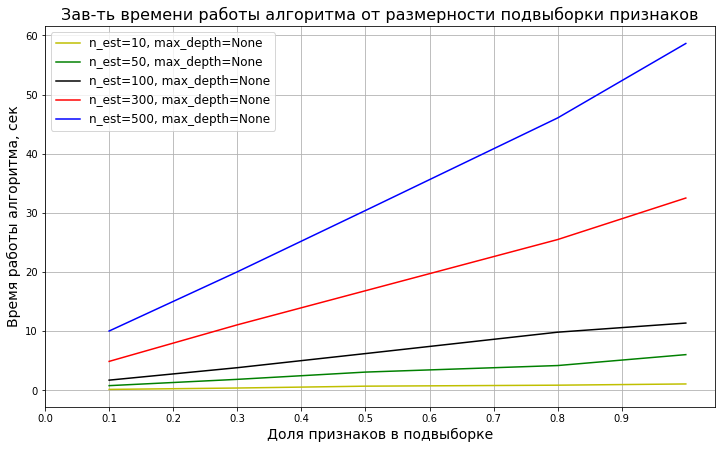

In [63]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть времени работы алгоритма от размерности подвыборки признаков", fontsize=16)
plt.xlabel("Доля признаков в подвыборке", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)


depth = None
value_dict = {}
for n_estimators in n_estimators_list_rf:
    value_dict[n_estimators] = []
    for feature_subsample_size in feature_subsample_size_list_rf:
            value_dict[n_estimators].append(time_dict_rf[n_estimators][feature_subsample_size][depth])
    
plt.plot(feature_subsample_size_list_rf, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[300], color="r", label="n_est=300, max_depth=" + str(depth))
plt.plot(feature_subsample_size_list_rf, value_dict[500], color="b", label="n_est=500, max_depth=" + str(depth))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0, 1, 0.1))
plt.grid()
plt.show()
# fig.savefig("time_size_None.pdf", bbox_inches = 'tight')

### №3

Исследуйте поведение алгоритма градиентный бустинг. Изучите зависимость RMSE на отложенной
выборке и время работы алгоритма в зависимости от следующих факторов:

•количество деревьев в ансамбле

•размерность подвыборки признаков для одного дерева

•максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)

•выбранный learning_rate (каждый новый алгоритм добавляется в композицию с коэффициентом
α · learning_rate )

In [74]:
n_estimators_list_gb = [1, 5, 10, 20, 50, 100, 200, 300] # 8
feature_subsample_size_list_gb = [0.1, 0.3, 0.5, 0.8, 1.0] # 5
max_depth_list_gb = [1, 3, 5, 7, 10, 15, None] # 7
learning_rate_list_gb = [0.001, 0.01, 0.1, 1.0] # 4
# 1120

In [75]:
rmse_dict_gb = {}
time_dict_gb = {}
best_rmse_gb = 10**6
best_param_gb = (0, 0, 0, 0)
global_start_time = time.time()


for n_estimators in n_estimators_list_gb:
    rmse_dict_gb[n_estimators] = {}
    time_dict_gb[n_estimators] = {}
    for feature_subsample_size in feature_subsample_size_list_gb:
        rmse_dict_gb[n_estimators][feature_subsample_size] = {}
        time_dict_gb[n_estimators][feature_subsample_size] = {}
        for max_depth in max_depth_list_gb:
            rmse_dict_gb[n_estimators][feature_subsample_size][max_depth] = {}
            time_dict_gb[n_estimators][feature_subsample_size][max_depth] = {}
            for learning_rate in learning_rate_list_gb:
                regressor = GradientBoostingMSE(n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                                            feature_subsample_size=feature_subsample_size, random_state=42)
                start_time = time.time()
                regressor.fit(X_train, y_train)
                fit_time = time.time() - start_time

                y_pred = regressor.predict(X_test)

                rmse = mean_squared_error(y_test, y_pred, squared=False)
                if rmse < best_rmse_gb:
                    best_rmse_gb = rmse
                    best_param_gb = (n_estimators, feature_subsample_size, max_depth, learning_rate)

                rmse_dict_gb[n_estimators][feature_subsample_size][max_depth][learning_rate] = rmse
                time_dict_gb[n_estimators][feature_subsample_size][max_depth][learning_rate] = fit_time

global_time_gb = time.time() - global_start_time

In [76]:
print("Общее время обучения для GradientBoostingMSE %5.2f секунд" % (global_time_gb))
print(f"Лучший RMSE для GradientBoostingMSE: {best_rmse_gb:.3f}")
print("Лучшие параметры для GradientBoostingMSE:", best_param_gb)

Общее время обучения для GradientBoostingMSE 3412.04 секунд
Лучший RMSE для GradientBoostingMSE: 125139.457
Лучшие параметры для GradientBoostingMSE: (300, 0.5, 5, 0.1)


Общее время обучения для GradientBoostingMSE: 57 минут

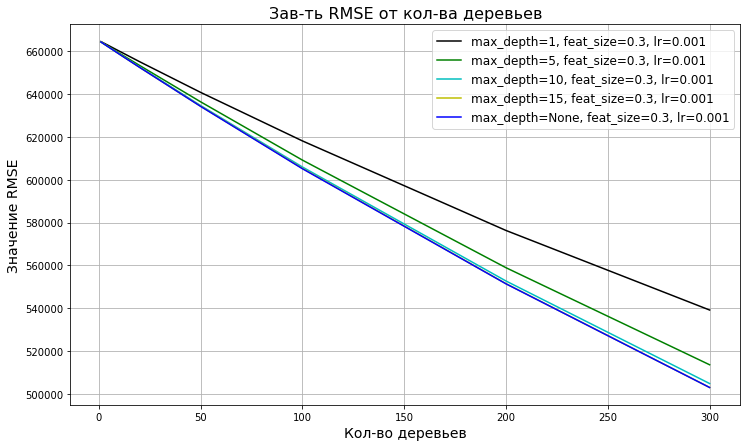

In [132]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)

size = 0.3
lr = 0.001
value_dict = {}
for max_depth in max_depth_list_gb:
    value_dict[max_depth] = []
    for n_estimators in n_estimators_list_gb:
            value_dict[max_depth].append(rmse_dict_gb[n_estimators][size][max_depth][lr])
    
plt.plot(n_estimators_list_gb, value_dict[1], color="k", label="max_depth=1, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[5], color="g", label="max_depth=5, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[10], color="c", label="max_depth=10, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[15], color="y", label="max_depth=15, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[None], color="b", label="max_depth=None, feat_size=" + str(size) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("n_0001_s03.pdf", bbox_inches = 'tight')

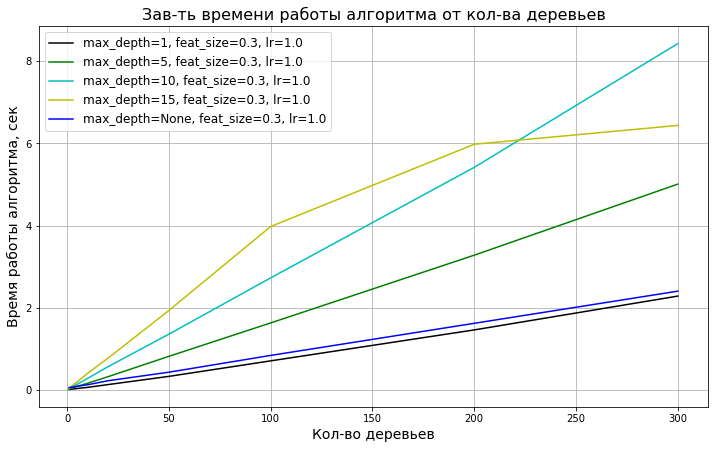

In [131]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть времени работы алгоритма от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)

size = 0.3
lr = 1.0
value_dict = {}
for max_depth in max_depth_list_gb:
    value_dict[max_depth] = []
    for n_estimators in n_estimators_list_gb:
            value_dict[max_depth].append(time_dict_gb[n_estimators][size][max_depth][lr])
    
plt.plot(n_estimators_list_gb, value_dict[1], color="k", label="max_depth=1, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[5], color="g", label="max_depth=5, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[10], color="c", label="max_depth=10, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[15], color="y", label="max_depth=15, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(n_estimators_list_gb, value_dict[None], color="b", label="max_depth=None, feat_size=" + str(size) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("time_n_1_s03.pdf", bbox_inches = 'tight')

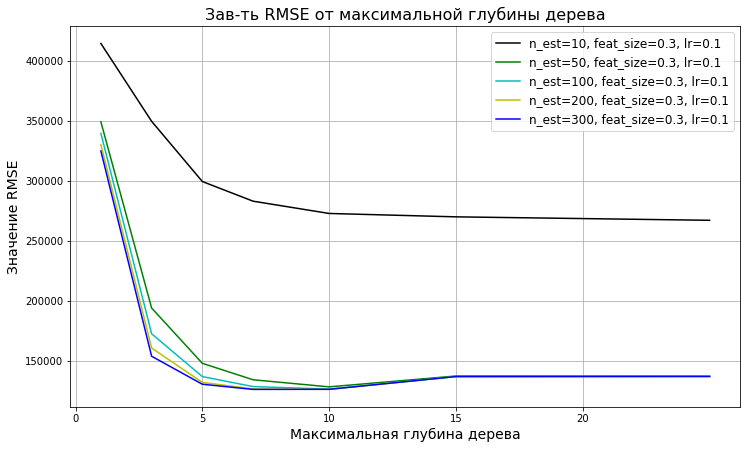

In [63]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть RMSE от максимальной глубины дерева", fontsize=16)
plt.xlabel("Максимальная глубина дерева", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)
            
size = 0.3
lr = 0.1
max_depth_list_gb_None = [1, 3, 5, 7, 10, 15, 25]
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for max_depth in max_depth_list_gb:
            value_dict[n_estimators].append(rmse_dict_gb[n_estimators][size][max_depth][lr])
            
plt.plot(max_depth_list_gb_None, value_dict[10], color="k", label="n_est=10, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[50], color="g", label="n_est=50, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[100], color="c", label="n_est=100, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[200], color="y", label="n_est=200, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[300], color="b", label="n_est=300, feat_size=" + str(size) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0, 24, 5))
plt.grid()
plt.show()
# fig.savefig("depth_01_s03.pdf", bbox_inches = 'tight')

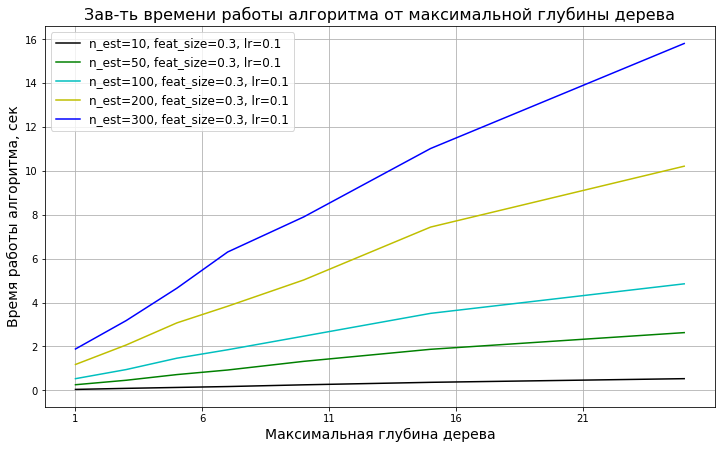

In [64]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
    
plt.title("Зав-ть времени работы алгоритма от максимальной глубины дерева", fontsize=16)
plt.xlabel("Максимальная глубина дерева", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)
            
size = 0.3
lr = 0.1
max_depth_list_gb_None = [1, 3, 5, 7, 10, 15, 25]
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for max_depth in max_depth_list_gb:
            value_dict[n_estimators].append(time_dict_gb[n_estimators][size][max_depth][lr])
            
plt.plot(max_depth_list_gb_None, value_dict[10], color="k", label="n_est=10, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[50], color="g", label="n_est=50, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[100], color="c", label="n_est=100, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[200], color="y", label="n_est=200, feat_size=" + str(size) + ", lr=" + str(lr))
plt.plot(max_depth_list_gb_None, value_dict[300], color="b", label="n_est=300, feat_size=" + str(size) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(1, 24, 5))
plt.grid()
plt.show()
# fig.savefig("time_depth_01_s03.pdf", bbox_inches = 'tight')

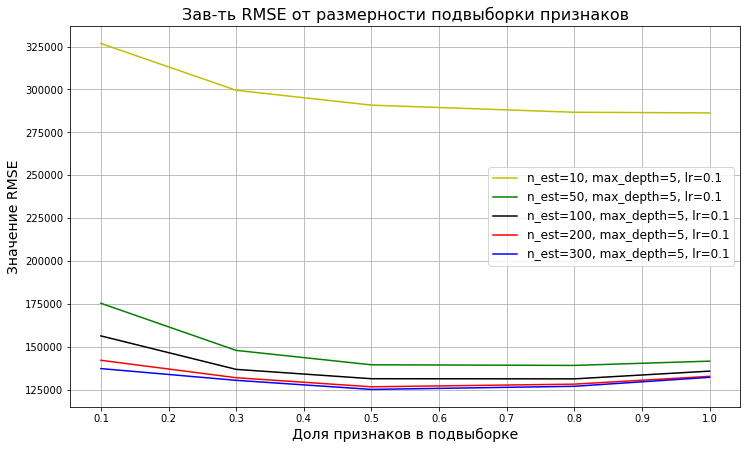

In [81]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от размерности подвыборки признаков", fontsize=16)
plt.xlabel("Доля признаков в подвыборке", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)


depth = 5
lr = 0.1
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for feature_subsample_size in feature_subsample_size_list_gb:
            value_dict[n_estimators].append(rmse_dict_gb[n_estimators][feature_subsample_size][depth][lr])

plt.plot(feature_subsample_size_list_gb, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[200], color="r", label="n_est=200, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[300], color="b", label="n_est=300, max_depth=" + str(depth) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.grid()
plt.show()
# fig.savefig("size_5_lr01.pdf", bbox_inches = 'tight')

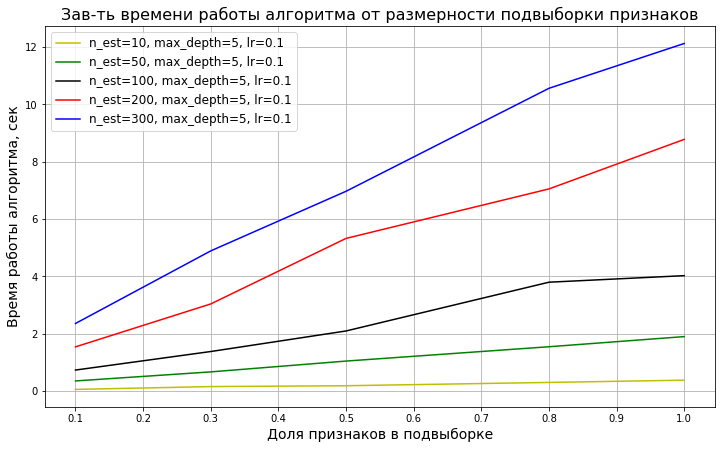

In [82]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть времени работы алгоритма от размерности подвыборки признаков", fontsize=16)
plt.xlabel("Доля признаков в подвыборке", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)


depth = 5
lr = 0.1
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for feature_subsample_size in feature_subsample_size_list_gb:
            value_dict[n_estimators].append(time_dict_gb[n_estimators][feature_subsample_size][depth][lr])

plt.plot(feature_subsample_size_list_gb, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[200], color="r", label="n_est=200, max_depth=" + str(depth) + ", lr=" + str(lr))
plt.plot(feature_subsample_size_list_gb, value_dict[300], color="b", label="n_est=300, max_depth=" + str(depth) + ", lr=" + str(lr))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.grid()
plt.show()
# fig.savefig("time_size_5_lr01.pdf", bbox_inches = 'tight')

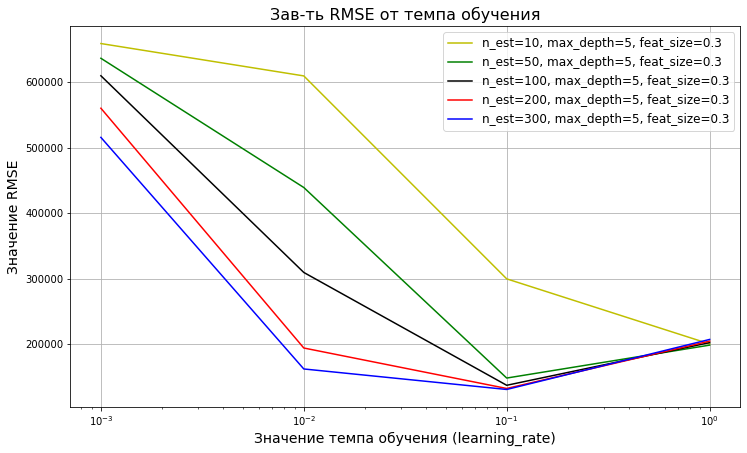

In [85]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от темпа обучения", fontsize=16)
plt.xlabel("Значение темпа обучения (learning_rate)", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)


depth = 5
size = 0.3
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for learning_rate in learning_rate_list_gb:
            value_dict[n_estimators].append(rmse_dict_gb[n_estimators][size][depth][learning_rate])

plt.plot(learning_rate_list_gb, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[200], color="r", label="n_est=200, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[300], color="b", label="n_est=300, max_depth=" + str(depth) + ", feat_size=" + str(size))

ax.legend(loc=0, fontsize=12)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.xscale('log')
plt.grid()
plt.show()
# fig.savefig("lr_1_s08.pdf", bbox_inches = 'tight')

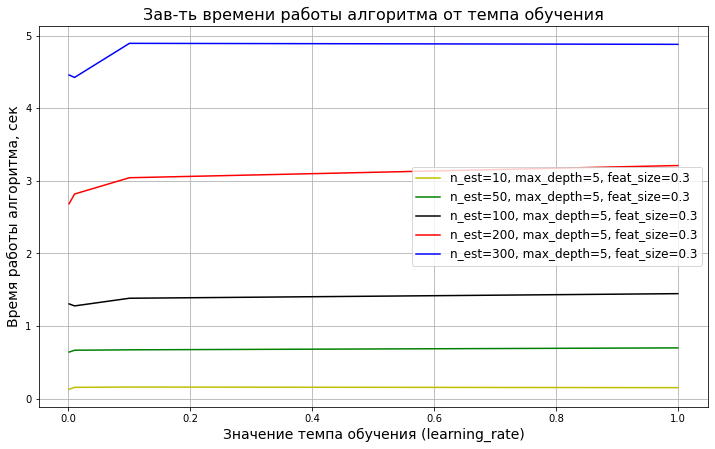

In [107]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть времени работы алгоритма от темпа обучения", fontsize=16)
plt.xlabel("Значение темпа обучения (learning_rate)", fontsize=14)
plt.ylabel("Время работы алгоритма, сек", fontsize=14)


depth = 10
size = 0.3
value_dict = {}
for n_estimators in n_estimators_list_gb:
    value_dict[n_estimators] = []
    for learning_rate in learning_rate_list_gb:
            value_dict[n_estimators].append(time_dict_gb[n_estimators][size][depth][learning_rate])

plt.plot(learning_rate_list_gb, value_dict[10], color="y", label="n_est=10, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[50], color="g", label="n_est=50, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[100], color="k", label="n_est=100, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[200], color="r", label="n_est=200, max_depth=" + str(depth) + ", feat_size=" + str(size))
plt.plot(learning_rate_list_gb, value_dict[300], color="b", label="n_est=300, max_depth=" + str(depth) + ", feat_size=" + str(size))

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("time_lr_1_s08.pdf", bbox_inches = 'tight')

### Дополнительные эксперименты

In [ ]:
n_estimators_cont_rf = 5000

start_time = time.time()
regressor = RandomForestMSE(n_estimators_cont_rf, random_state=42, continuity=True)
regressor.fit(X_train, y_train)
rmse_list_cont_rg = regressor.predict_y(X_test, y_test)
print("Время обучения для RandomForestMSE %5.2f секунд" % (time.time() - start_time))

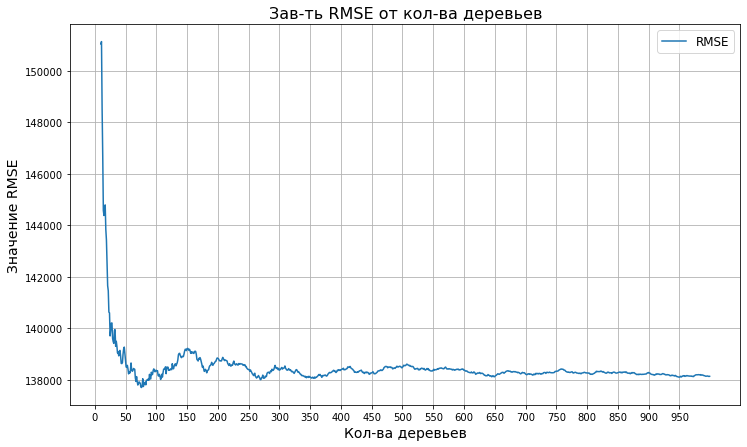

In [16]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)

kol = list(range(n_estimators_cont_rf))

plt.plot(kol[10:], rmse_list_cont_rg[10:], label="RMSE")

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.xticks(np.arange(0, 1000, 50))
plt.show()
# fig.savefig("n_5000.pdf", bbox_inches = 'tight')

In [50]:
n_estimators_cont_gb = 5000

start_time = time.time()
regressor = GradientBoostingMSE(n_estimators_cont_gb, random_state=42, continuity=True)
regressor.fit(X_train, y_train)
rmse_list_cont_gb = regressor.predict_y(X_test, y_test)
print("Время обучения для GradientBoostingMSE %5.2f секунд" % (time.time() - start_time))

Время обучения для GradientBoostingMSE 90.30 секунд


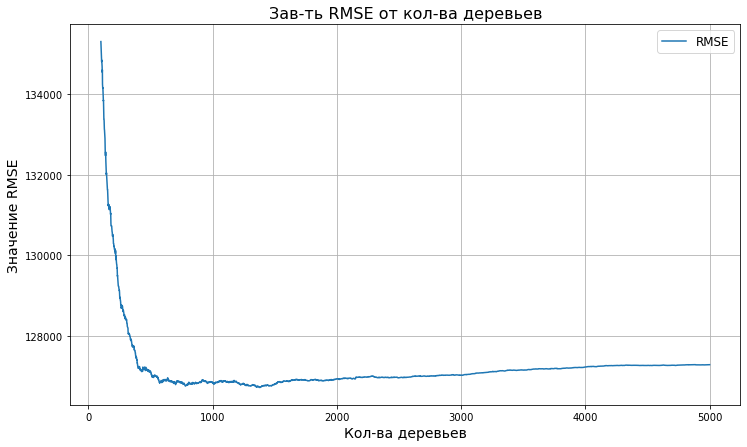

In [54]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

plt.title("Зав-ть RMSE от кол-ва деревьев", fontsize=16)
plt.xlabel("Кол-во деревьев", fontsize=14)
plt.ylabel("Значение RMSE", fontsize=14)

kol = list(range(n_estimators_cont_gb))

plt.plot(kol[100:], rmse_list_cont_gb[100:], label="RMSE")

ax.legend(loc=0, fontsize=12)
plt.grid()
plt.show()
# fig.savefig("gb_n_100_5000.pdf", bbox_inches = 'tight')